In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, Normalize, CenterCrop
import torch.optim as optim
from PIL import Image

import matplotlib.pyplot as plt


torch.__version__

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

## Get data

Subset of Food101 Dataset (3) classes and 10% of data

75 training images per class and 25 testing images

In [2]:
import requests
import zipfile
from pathlib import Path

# Create data directory
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} is already extracted')
else:
    print(f'Extracting {image_path}')
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(r.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi is already extracted
Downloading...
Unzipping...


### Becoming one with the Data (Data prep and exploration)

In [3]:
import os


def walk_through_dir(dir_path):
    
    '''
    Walks through dir_path returning its contents as a tuple (dirpath, dirnames, filenames)
    
    Args:
    dir_path (str): Path to directory
    
    Returns:
    None
    '''
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [4]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## Vizualing and Image for Preprocessing

Write code to: 
1. Get all image path
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using  `pathlib.Path.parent.stem`
4. Since I'm working with images, I'll use PIL (Python Image Library) 
5. Show image and print metadata

In [5]:
import random
from PIL import Image
from pathlib import Path


# Set seed
#random.seed(42)

# Get all image file paths
image_paths = list(image_path.glob("*/*/*.jpg"))

image_paths[-5:]

# Get class name from image path
random_image_path = random.choice(image_paths)
class_names = random_image_path.parent.stem
print(class_names[:])

# Open image
img = Image.open(random_image_path)


# Print the metadata
print(f"""
    Image Class: {class_names}
    Image Size: {img.size}
    Image Path: {random_image_path}    
    """)

steak

    Image Class: steak
    Image Size: (512, 384)
    Image Path: data\pizza_steak_sushi\train\steak\1615395.jpg    
    


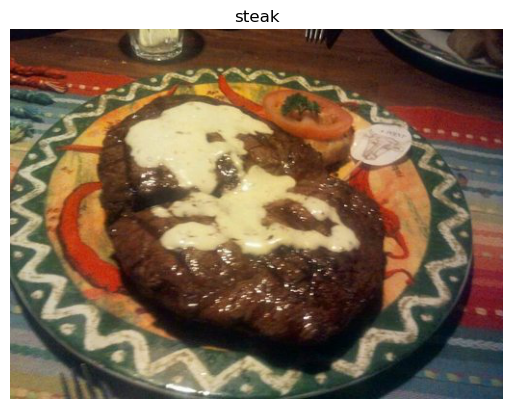

In [6]:
### Visulize the data using matplotlib

import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(class_names)
plt.axis(False);


### Transforming data

Before using the image with PyTorch:
1. Turn target data into tensors 
2. Turn it into a `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader

In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [8]:
# Write a transformer to convert images
data_transform = transforms.Compose([
    
    #Resize the image to (64, 64)
    transforms.Resize((64, 64)),
    
    #Flip the image horizontally
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    
    #Convert the image to a tensor
    transforms.ToTensor()
    ])



<Figure size 1000x700 with 0 Axes>

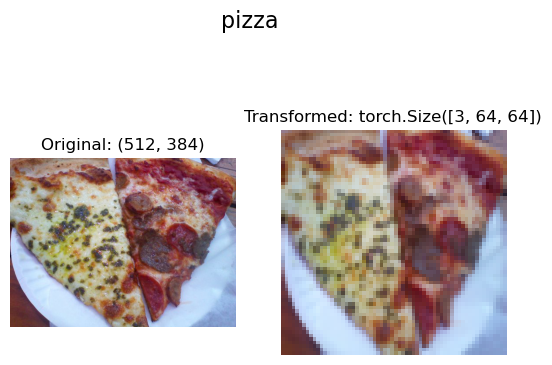

<Figure size 1000x700 with 0 Axes>

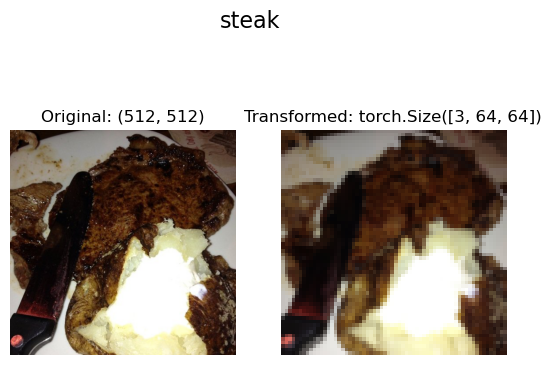

<Figure size 1000x700 with 0 Axes>

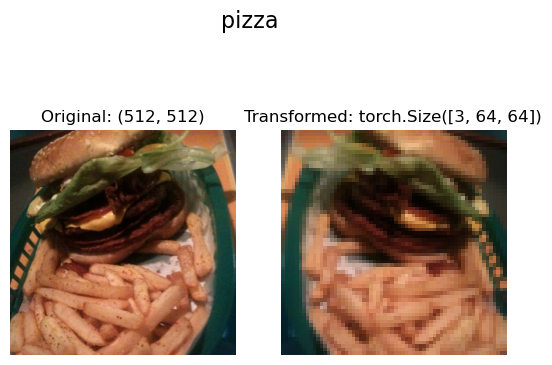

In [9]:
import random
import torch
from PIL import Image
import glob
def plot_transformed_image(image, transform, n=3, seed=None):
    
    '''
    Selects random images from the path of images and loads and transforms them and  
    plot the transformed images
    
    Args:
    image (PIL image): The image to transform
    transform (transform): The image transform
    n (int): The number of images to plot
    seed (int): The random seed to use
    
    Returns:
    None
    '''
    
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            plt.figure(figsize=(10, 7))
            fig, axis = plt.subplots(1, 2)
            axis[0].imshow(f)
            axis[0].set_title(f"Original: {f.size}")
            axis[0].axis(False)
            
            # Transform the image and plot both the original and transformed image
            transformed_image = transform(f)
            axis[1].imshow(transformed_image.permute(1, 2, 0))
            axis[1].set_title(f"Transformed: {transformed_image.shape}")
            axis[1].axis(False)
            
            fig.suptitle(image_path.parent.stem, fontsize=16)
    
    
plot_transformed_image(img, 
                        data_transform,
                        n=3,
                        )

### Option 1: Loading image data from `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` by passing it the root directory of our data. It assumes the data is organized in the following way:
* root/dog/xxx.png
* root/dog/xxy.png
* root/dog/xxz.png
* root/cat/123.png
* root/cat/nsdf3.png
* root/cat/asd932_.png

In [10]:
# Use the Image Folder to create datasets
from cgi import test
from torchvision import datasets

# Create the training dataset

train_dataset = datasets.ImageFolder(root= train_dir, 
                                    transform=data_transform,
                                    target_transform=None)

test_dataset = datasets.ImageFolder(root= test_dir, 
                                    transform=data_transform)

test_dataset,  train_dataset

C:\Users\jakev\AppData\Local\Temp\ipykernel_10148\4056895025.py:2: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  from cgi import test


(Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.25)
                RandomVerticalFlip(p=0.25)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.25)
                RandomVerticalFlip(p=0.25)
                ToTensor()
            ))

In [11]:
# Get the class names as a list
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
class_dict = train_dataset.class_to_idx

In [13]:
# Get the length of the training dataset and the test dataset
len(train_dataset), len(test_dataset)

(225, 75)

In [14]:
# Index on the train_data to get a sample image and label
img, label = train_dataset[0][0], train_dataset[0][1]
print(f"""
    Image tensor: \n {img}
    Image shape: {img.shape}
    Image data type: {img.dtype}
    Image label: {label}
    Label data type: {type(label)}
    """)


    Image tensor: 
 tensor([[[0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137]],

        [[0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         ...,
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745]],

        [[0.1765, 0.1804, 0.1843,  ..., 0.1059, 0.1020, 0.1059],
         [0.1804, 0.1843, 0.1922,  ..., 0.1255, 0.1137, 0.1098],
         [0.1804, 0.1882, 0.1961,  ..

In [15]:
class_names[label]

'pizza'

Permuted Shape:torch.Size([64, 64, 3]), torch.float32
Orginial Shape:torch.Size([3, 64, 64]), torch.float32


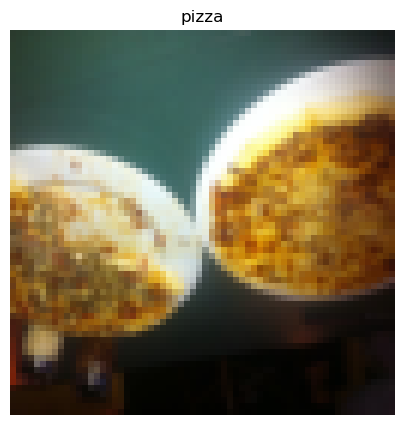

In [16]:
# Rearrange the tensor to (H, W, C)
img_permute = img.permute(1, 2, 0)

# Print out the image tensor shape and data type
print(f'Permuted Shape:{img_permute.shape}, {img_permute.dtype}')
print(f'Orginial Shape:{img.shape}, {img.dtype}')

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis(False);



### 4.1 Turn Loaded images into DataLoader's

A data loader is Going to help us run our `Dataset` into iterables and we can customize the `batch_size` so our model can see batch size images at the same time



In [17]:
# Turn the training and testing data into DataLoader's

BATCH_SIZE = 32
NUM_WORKERS = 5
train_data_loader= DataLoader(dataset=train_dataset, 
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=True)

test_data_loader = DataLoader(dataset=test_dataset, 
                    batch_size=BATCH_SIZE, 
                    shuffle=False,
                    num_workers=NUM_WORKERS)

train_data_loader, test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x22622da6f90>,
 <torch.utils.data.dataloader.DataLoader at 0x22620a3a490>)

In [18]:
len(train_data_loader), len(test_data_loader)

(8, 3)

In [19]:
img, label = next(iter(train_data_loader))

print(f"""
    Image Shape: {img.shape} --> (batch_size, channels, height, width)
    Label Shape: {label.shape}
    """)


    Image Shape: torch.Size([32, 3, 64, 64]) --> (batch_size, channels, height, width)
    Label Shape: torch.Size([32])
    


### Option 2: Loading data with a custom dataset class

1. Want to be able to pull out images from a file
2. Want to be able to get a class names from the data set
3. To be able to get class named as a dictionary from the data set

*Pros*
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

*Cons*
* Even though you **could** create a `Dataset` out of almost anything, it does not mean it will work
* Using a custom `Dataset` often results in writing more code and is more prone to errors or performance issues

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [21]:
# Instance of torchvision.datasets.ImageFolder()
train_dataset.classes, train_dataset.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper fucntion to get the class names

Create a function to:
1. Get the class names using `os.scandir` to find the target directories 
2. Raise an error if the class names aren't found
3. Turn the class names into a dictionary and list and return them


In [22]:
# Set path for the data
target_directory = str(train_dir)
print(f'Target Directory: {target_directory}')

# Get the class names
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directory: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [23]:
import os
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    
    '''
    Finds the class folders in a dataset.
    
    Args:
    directory (str): Root directory path.
    
    Returns:
    Tuple[List[str], Dict[str, int]]: Tuple of (class_names, class_to_idx)
    '''
    
    # Get the classes by scanning the directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # Raise an error if lass names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
    
    # Create a dictionary that maps class names to indices
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

### Create a custom `Dataset` to replicate `ImageFolder`

To create a custom dataset:
1. Subclass `torch.utils.data.Dataset`
2. Init our class with a target directory (the directory used to get the data from) and transform the data
3. Create several attributes:
    * `paths` - paths of images
    * `transforms` - the transform we'd like to use
    * `classes` - a list of the target classes
    * `class_to_idx` - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()` which will open an image
5. Overwrite the `__len__()` to return the length of the dataset
6. Overwrite the `__getitem__` to return a given sample when passed an index

In [24]:
# Write a custom dataset class
from torch.utils.data import Dataset
import glob
import os

# Subclass torch.utils.data.Dataset


class ImageFolderCustom(Dataset):
    # Define the init method
    def __init__(self,
                target_directory: str,
                transform=None) -> None:

        # Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(target_directory).glob('*/*.jpg'))

        # Set the transform
        self.transforms = transform

        # Get the class names and class_to_idx
        self.class_names, self.class_to_idx = find_classes(target_directory)

    # Create a function to load an image and its label
    def load_image(self, index: int) -> Image.Image:
        """Opens and image via a path and returns it"""

        image_path = self.paths[index]
        return Image.open(image_path)
    
    # Overwrite __len__()
    def __len__(self):
        """Returns the length of the dataset"""
        return len(self.paths)
    
    # Overwrite __getitem__() method to return a sample from the dataset
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    
        """Returns one sample of data, data and label (X,y)"""
        
        # Load the image
        img = self.load_image(index)
        
        # Get the class name for this image
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        
        # Get the class index for this image
        class_idx = self.class_to_idx[class_name]
        
        # Apply the transform
        if self.transforms:
            return self.transforms(img), class_idx # return data (X,y)
        else:
            return img, class_idx # return data (X,y)


In [25]:
from torchvision import transforms


# Create a transform
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(25),
    transforms.RandomAffine(degrees=(30,70), shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])

In [26]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(target_directory=train_dir, 
                                    transform=train_transform)

test_data_custom = ImageFolderCustom(target_directory=test_dir,
                                    transform=test_transform)

In [27]:
print(len(train_data_custom), len(test_data_custom))
print(len(train_dataset), len(test_dataset))

225 75
225 75


In [28]:
train_data_custom.class_names, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [29]:
print(train_dataset.class_to_idx == train_data_custom.class_to_idx)
print(train_dataset.class_to_idx == test_data_custom.class_to_idx)

print(train_data_custom.class_names == train_dataset.classes)

True
True
True


## Visualize Vizualize Vizualize
#### Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, cap the number of images to 10
3. Set the random seed for reproducibility
4. Get a list of random samples indexes from the target dataset
5. Setup a matplotlib plot 
6. Loop through the dimensions of the images and plot them
7. Align dimensions up with matplotlib (HWC)

In [30]:
from typing import List
from matplotlib.pylab import random_sample
import matplotlib.pyplot as plt
import random

#1. Create a function to plot images in a grid
def display_random_images(dataset: torch.utils.data.Dataset,
                        classes: List[str] = None,
                        n: int = 10,
                        display_shape: bool = True,
                        seed: int = None):
    """
    Display random images from a dataset.
    
    Args:
        dataset (torch.utils.data.Dataset): The dataset containing the images.
        classes (List[str], optional): List of class labels. Defaults to None.
        n (int, optional): Number of random images to display. Defaults to 10.
        display_shape (bool, optional): Whether to display the shape of the images. Defaults to True.
        seed (int, optional): Random seed for reproducibility. Defaults to None.
    """
    # Rest of the code...
def display_random_images(dataset: torch.utils.data.Dataset,
                        classes: List[str] = None,
                        n: int = 10,
                        display_shape: bool = True,
                        seed: int = None):
    
    """
    
    """
    # 2. Adjust display if n is greater than 10
    if n > 10:
        n = 10
        display_shape = False
        print("Displaying 10 images only. Set display_shape to True to display the shape of the images.")
    
    # 3. Set the seed
    if seed:
        random.seed(seed)
        torch.manual_seed(seed)
    
    # 4. Get random indices for images
    indices = random.sample(range(len(dataset)), k=n)
    
    # 5. Setup the plot
    plt.figure(figsize=(16, 8))
    
    # 6. Loop over indices and plot images
    for i, targ_sample in enumerate(indices):
        targ_image, targ_label = dataset[targ_sample]
    
        # 7. Adjust the shape of the image tensor 
        targ_image_adjust = targ_image.permute(1, 2, 0)
        
        # Plot Adjusted Samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)

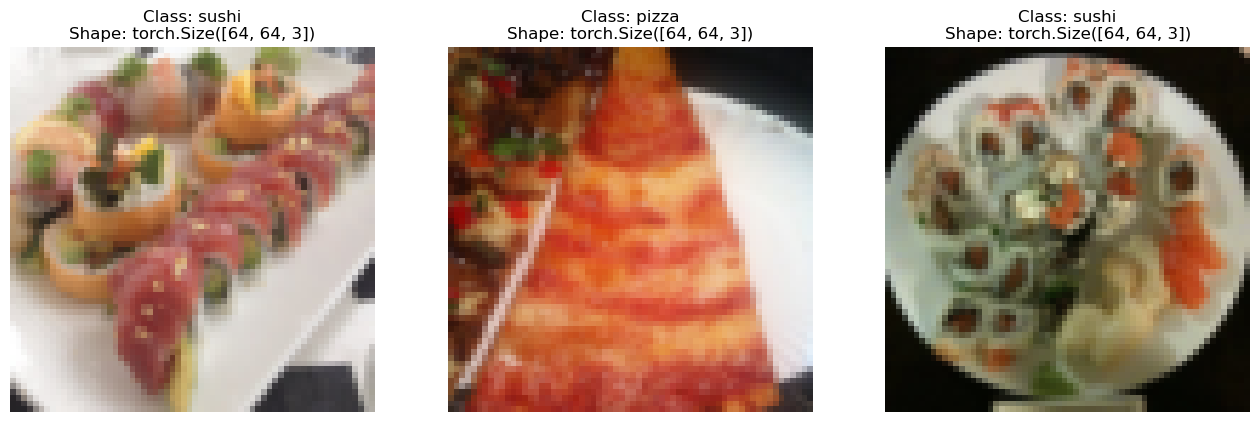

In [31]:
# Display random images from ImagesFolder created dataset
display_random_images(train_dataset, 
                    classes=class_names, 
                    n=3)

Displaying 10 images only. Set display_shape to True to display the shape of the images.


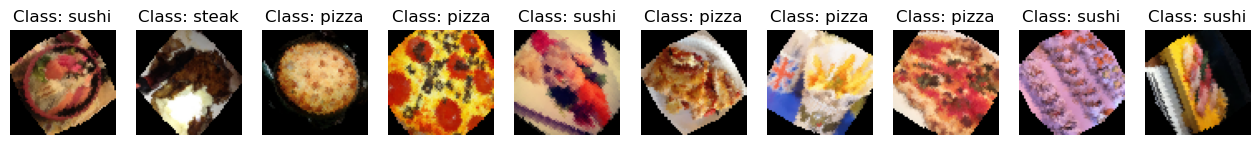

In [32]:
# Display random images from ImagesFolderCustom created dataset
import dis


display_random_images(train_data_custom,
                    classes=train_data_custom.class_names,
                    n=20,
)


In [33]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [34]:
NUM_WORKERS

0

In [35]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### Other forms of tranforms

Data augmentation is the process of artificially adding diversity to your training data 

For image data this means applying various image transformations to training images

One particular type of extremely important type of data augmentation is `trivialaugment`

In [36]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [37]:
# Get all image paths


image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg')]

<Figure size 1000x700 with 0 Axes>

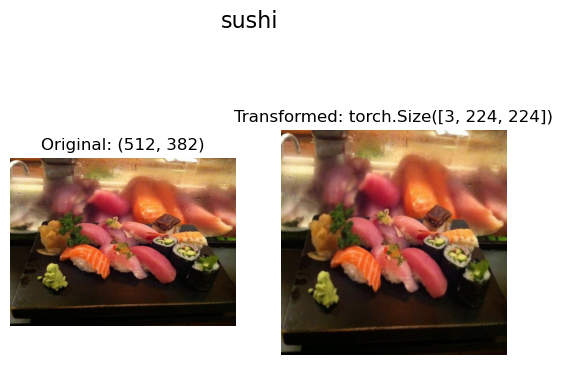

<Figure size 1000x700 with 0 Axes>

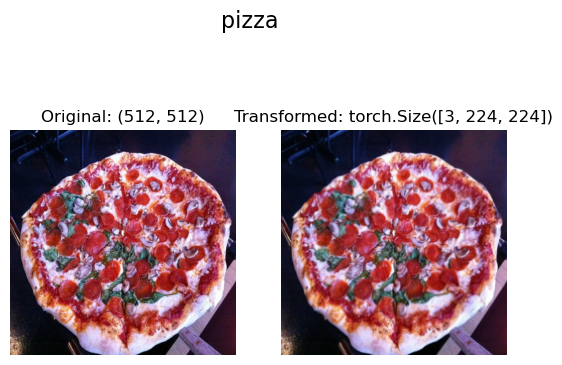

<Figure size 1000x700 with 0 Axes>

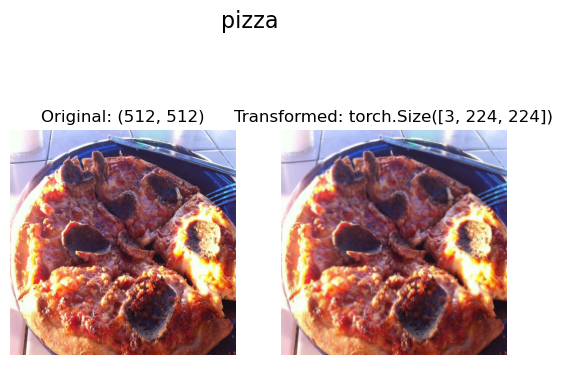

<Figure size 1000x700 with 0 Axes>

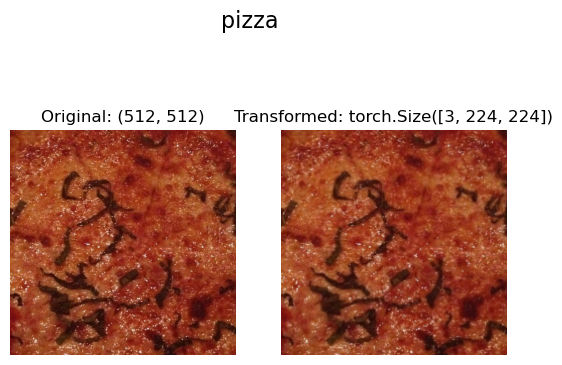

<Figure size 1000x700 with 0 Axes>

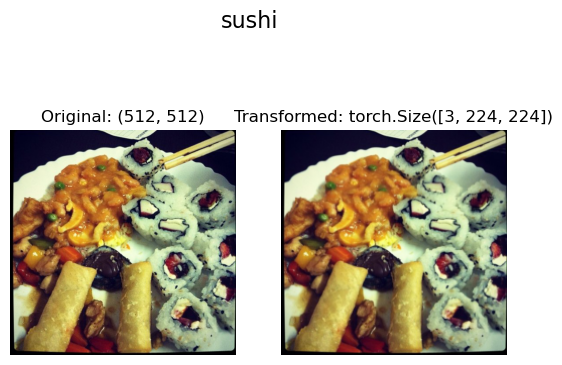

In [38]:
# Plot random images from the image_path_list
plot_transformed_image(image=image_path_list,
                        transform=train_transform,
                        n=5,)

## Model 0: TinyVGG Baseline (without data augmentation)

Replicate the TinyVGG from the CNN Explainer Website


### Creating transforms and loading Model 0

In [39]:
# Create simple transforms

from torch.utils.data import DataLoader
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [40]:
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, 
                                        transform=simple_transform,
                                        )
test_data_simple = datasets.ImageFolder(root=test_dir, 
                                        transform=simple_transform,
                                        )

# Turn the datasets into dataloaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = 0

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [41]:
NUM_WORKERS

0

## BASELINE MODEL

In [42]:
# Replicate the TinyVGG model

from numpy import pad
import torch.nn as nn


class TinyVGG_V0(nn.Module):
    def __init__(self,
                input_shape: int = 3,
                hidden_units: int = 10,
                output_shape: int = 3) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),

            nn.ReLU(),

            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2,
                        stride=2))

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),

            nn.ReLU(),

            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0,
            ),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*13*13, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        '''Benefits from operator fusion'''

        x = self.conv_block_1(x)
        # print(f'x shape after conv_block_1: {x.shape}')
        x = self.conv_block_2(x)
        # print(f'x shape after conv_block_2: {x.shape}')
        x = self.classifier(x)
        # print(f'x shape after classifier: {x.shape}')
    
        return x

In [43]:

torch.manual_seed(42)
Model_V0 = TinyVGG_V0(
    input_shape=3,
    hidden_units=10,
    output_shape=3,
).to(device)

Model_V0.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.1471,  0.1597, -0.0451],
                        [ 0.1768, -0.0422,  0.0388],
                        [-0.0937,  0.1130,  0.1697]],
              
                       [[-0.1412,  0.1673,  0.0360],
                        [ 0.1422,  0.0261,  0.0928],
                        [-0.0272,  0.1484,  0.0284]],
              
                       [[-0.0898,  0.0491, -0.0887],
                        [-0.0226, -0.0782,  0.1277],
                        [-0.1519, -0.0887, -0.0543]]],
              
              
                      [[[-0.1157,  0.0182, -0.1901],
                        [ 0.1738, -0.1635,  0.1486],
                        [ 0.0320, -0.0625,  0.1189]],
              
                       [[ 0.0300,  0.1555,  0.0210],
                        [-0.0607,  0.0517, -0.0522],
                        [ 0.0810,  0.1718,  0.1112]],
              
                       [[-0.0841,  0.1111,  0.0344],
                 

### Try a forward pass on a single image

In [44]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [45]:
Model_V0(image_batch.to(device))

tensor([[ 0.0965, -0.0874, -0.1685],
        [ 0.0980, -0.0916, -0.1637],
        [ 0.0989, -0.0878, -0.1675],
        [ 0.0976, -0.0899, -0.1659],
        [ 0.0973, -0.0903, -0.1653],
        [ 0.0993, -0.0871, -0.1669],
        [ 0.0980, -0.0880, -0.1668],
        [ 0.0976, -0.0864, -0.1692],
        [ 0.0992, -0.0859, -0.1677],
        [ 0.0976, -0.0863, -0.1683],
        [ 0.0977, -0.0898, -0.1658],
        [ 0.0980, -0.0876, -0.1680],
        [ 0.0978, -0.0878, -0.1671],
        [ 0.0994, -0.0882, -0.1662],
        [ 0.0969, -0.0901, -0.1653],
        [ 0.0997, -0.0863, -0.1680],
        [ 0.0982, -0.0871, -0.1685],
        [ 0.0993, -0.0872, -0.1681],
        [ 0.0994, -0.0879, -0.1669],
        [ 0.1008, -0.0887, -0.1653],
        [ 0.0993, -0.0898, -0.1649],
        [ 0.0991, -0.0852, -0.1694],
        [ 0.0989, -0.0879, -0.1666],
        [ 0.0982, -0.0891, -0.1663],
        [ 0.1000, -0.0884, -0.1655],
        [ 0.0983, -0.0885, -0.1668],
        [ 0.0982, -0.0886, -0.1658],
 

In [46]:
import torchinfo
from torchinfo import summary

BATCH_SIZE = 32
summary(Model_V0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG_V0                               [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### Create a train and test loop fuctions

* `train_loop` - loops over our training data and trains our model
* `test_loop` - Loops over are testing data and evaluates our model

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [48]:
# Create the training loop
import torch
import torch.nn as nn

from helper_functions import accuracy_fn

def train_step(
                model: nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device = device):
    
    model.train()
    
    # Set the loss and accuracy to zero
    train_loss, train_acc = 0, 0
    
    # Loop over the training batches
    for batch, (X, y) in enumerate(dataloader):
        
        # Send the data to the device
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        
        # Calculate the loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Zero out the optimizer gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate the accuracy 
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    # Calculate the average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


# Create the testing loop
def test_step(
            model: nn.Module,
            dataloader: torch.utils.data.DataLoader,
            loss_fn: nn.Module,
            device: torch.device = device):
    
    model.eval()
    # Set the loss and accuracy to zero
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        # Loop over the testing batches
        for batch, (X, y) in enumerate(dataloader):
            
            # Send the data to the device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            # Calculate the loss and accuracy
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            # Calculate the accuracy 
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class==y).sum().item()/len(y_pred)
    
    # Calculate the average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

### Create a `train()` function to combine the training and testing loops

In [49]:
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


def train(
        model: nn.Module,
        train_loader: DataLoader,
        epochs: int,
        test_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: nn.Module = nn.CrossEntropyLoss(),
        device: torch.device = device):

    # Create empty lists to store losses and accuracies
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []}

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device)

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_loader,
            loss_fn=loss_fn,
            device=device)

        print(f"""
                _________________________________
                Epoch: {epoch+1}/{epochs}
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc*100:.2f}%
                Testing Loss: {test_loss:.4f} | Testing Accuracy:  {test_acc*100:.2f}%
                
                """)

        # Update results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the results at the end of the epochs
    return results

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [51]:
len(train_dataset.classes)

3

In [52]:
### Train and evaluate the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Recreate the instance of TinyVGG_V0
Model_V0 = TinyVGG_V0(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_dataset.classes)
).to(device)

print(next(Model_V0.parameters()).device)

# Set the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model_V0.parameters(), lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train Model_V0
model_0_results = train(
                    model=Model_V0,
                    train_loader=train_dataloader_simple,
                    epochs=NUM_EPOCHS,
                    test_loader=test_dataloader_simple,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device)

# End timer
end_time = timer()
total_time = end_time - start_time
print(f"Total time: {total_time:.2f} seconds")

cuda:0


  0%|          | 0/5 [00:00<?, ?it/s]


                _________________________________
                Epoch: 1/5
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.0886 | Training Accuracy: 42.58%
                Testing Loss: 1.1139 | Testing Accuracy:  26.04%
                
                

                _________________________________
                Epoch: 2/5
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.1079 | Training Accuracy: 30.47%
                Testing Loss: 1.1057 | Testing Accuracy:  26.04%
                
                

                _________________________________
                Epoch: 3/5
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.0981 | Training Accuracy: 30.47%
                Testing Loss: 1.0749 | Testing Accuracy:  26.04%
                
                

                _________________________________
                Epo

In [53]:
model_0_results

{'train_loss': [1.0886237248778343,
  1.1078875660896301,
  1.0981434434652328,
  1.0851231664419174,
  1.0947941839694977],
 'train_acc': [0.42578125, 0.3046875, 0.3046875, 0.3359375, 0.3515625],
 'test_loss': [1.1139254172643025,
  1.1056918303171794,
  1.074864387512207,
  1.0633856455485027,
  1.0051407217979431],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.625,
  0.5729166666666666]}

### Plot the loss curves of the model

A lost curve is a way of tracking your model's progress over time

In [54]:
# Get the model_0 results over a time
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

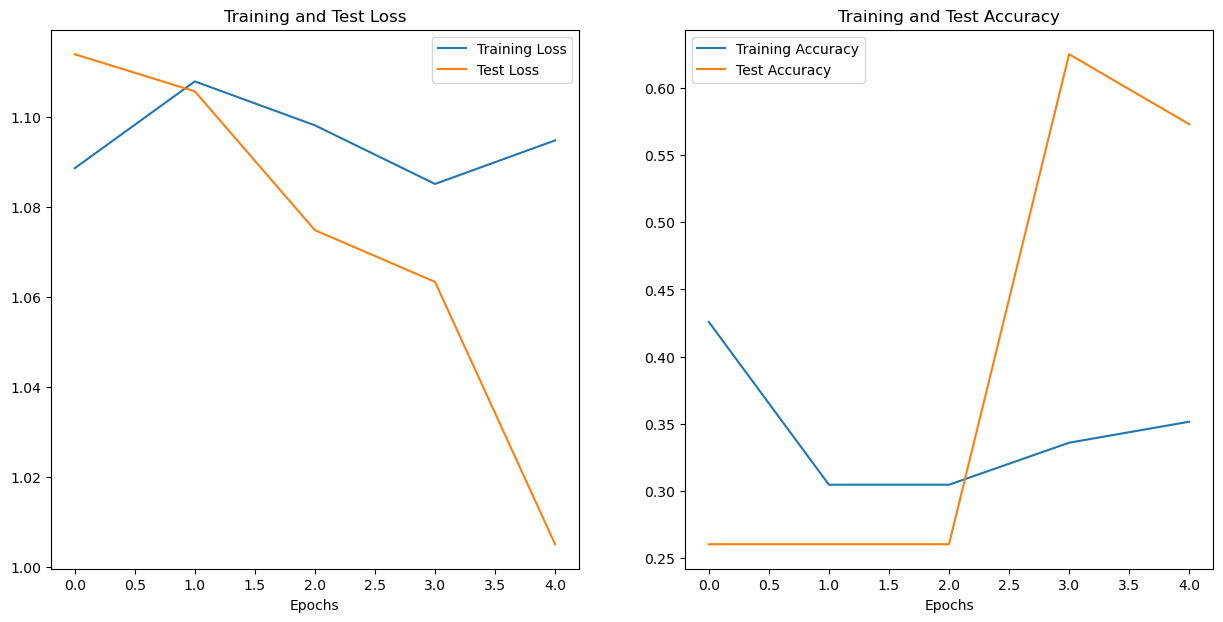

In [55]:
def plot_results(results: dict[str, List[float]]) -> None:
    """Plots the training curves of results dictionary"""
    
    # Get the loss values of the results dictionary(training and testing)
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    #Figure out how many epochs we trained for
    epochs = range(len(results['train_loss']))
    
    # Set up plot
    plt.figure(figsize=(15, 7))
    
    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_results(model_0_results)

### TinyVGG with Data Augmentation

Try another modeling experiment with same structure,  with data augmentation


In [56]:
# Create a function transform with TrivialAugmentWide
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### Create a train and test dataset with Dataset and DataLoader with data augmentation

In [57]:
import torch
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 16
NUM_WORKERS = 0

# Create a dataset
train_dataset_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial)

test_dataset_simple = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_simple)


# Create a dataloader
train_dataloader_augmented = DataLoader(
    dataset=train_dataset_augmented,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)

test_dataloader_simple = DataLoader(
    dataset=test_dataset_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False)

### Construct and train model 1

This time the training data is augmented with TrivialAugmentWide

In [58]:
Model_V1 = TinyVGG_V0(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_dataset.classes)).to(device)

Model_V1.state_dict()


OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.0596,  0.0401, -0.1238],
                        [ 0.0373,  0.1786,  0.1544],
                        [ 0.1024,  0.0231,  0.0915]],
              
                       [[ 0.1009, -0.0803, -0.0550],
                        [-0.0080,  0.0989, -0.1682],
                        [ 0.0338,  0.1371,  0.0585]],
              
                       [[-0.1458, -0.1057, -0.1719],
                        [-0.1557, -0.1548, -0.0153],
                        [-0.0794, -0.1864,  0.1709]]],
              
              
                      [[[ 0.0460, -0.1267, -0.1078],
                        [-0.0116,  0.1271, -0.0614],
                        [-0.0712,  0.1217, -0.0275]],
              
                       [[-0.0692,  0.1289, -0.1547],
                        [ 0.0511, -0.1673,  0.0075],
                        [-0.0336, -0.1308, -0.1023]],
              
                       [[ 0.1238,  0.1528,  0.0402],
                 

In [59]:
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Set the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model_V1.parameters(), lr=0.01)

# Start timer
from timeit import default_timer as timer
start = timer()

# Train Model_V1
model_1_results = train(
                    model=Model_V1,
                    train_loader=train_dataloader_augmented,
                    epochs=NUM_EPOCHS,
                    test_loader=test_dataloader_simple,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device)

# End timer

end = timer()
total_time = end - start

print(f"Total training time: {total_time:.2f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]


                _________________________________
                Epoch: 1/5
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.1739 | Training Accuracy: 30.00%
                Testing Loss: 1.1040 | Testing Accuracy:  23.75%
                
                

                _________________________________
                Epoch: 2/5
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.1022 | Training Accuracy: 31.25%
                Testing Loss: 1.1037 | Testing Accuracy:  23.75%
                
                

                _________________________________
                Epoch: 3/5
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.0989 | Training Accuracy: 31.25%
                Testing Loss: 1.1009 | Testing Accuracy:  31.25%
                
                

                _________________________________
                Epo

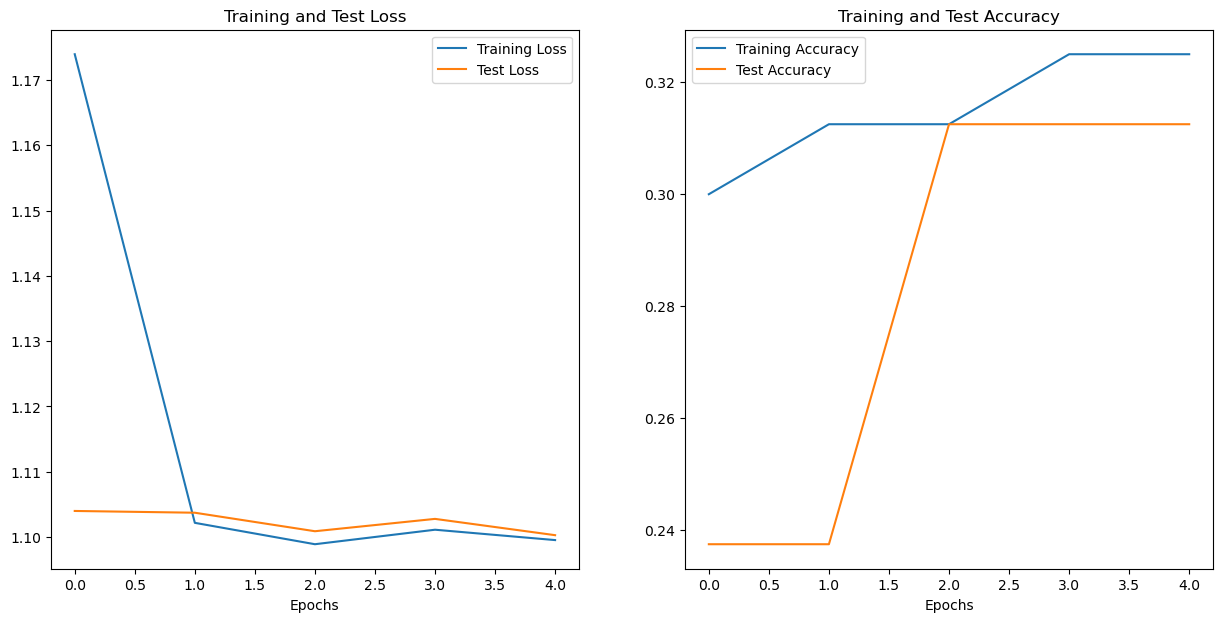

In [60]:
# Plot the loss and accuracy curves

plot_results(model_1_results)

### Compare model results

After evaluating our model experiments on their own, it's important to compare them to each other
Few ways to do this:

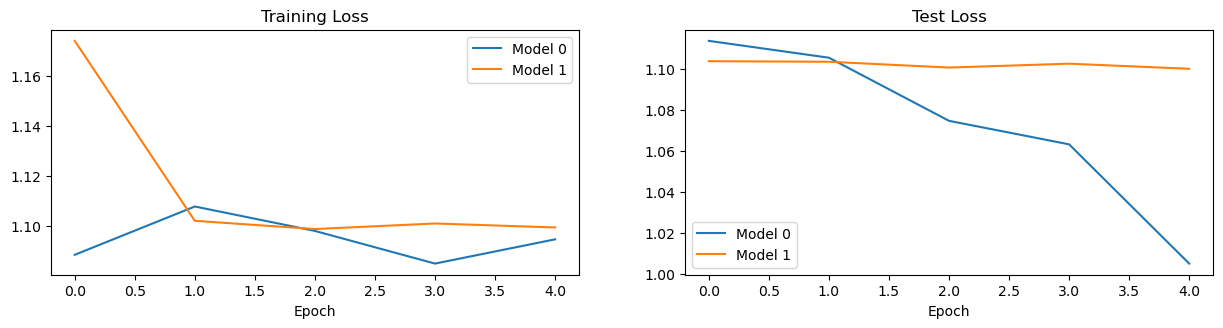

In [61]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

# Plot the loss curves for both models on the same plot
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 7))

# Get number of epochs
epochs = range(len(model_0_df))
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend();

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.legend();


### Experimental Model

In [62]:
# Replicate the TinyVGG model
import torch.nn as nn


class TinyVGG_V1(nn.Module):
    def __init__(self,
                input_shape: int = 3,
                hidden_units: int = 10,
                output_shape: int = 3) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),

            nn.ReLU(),

            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2,
                        stride=2))

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),

            nn.ReLU(),

            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2))
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),

            nn.ReLU(),

            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*7*7, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        '''Benefits from operator fusion'''
        
        """
        x = self.conv_block_1(x)
        print(f"conv_block_1 output shape: {x.shape}")
        x = self.conv_block_2(x)
        print(f"conv_block_2 output shape: {x.shape}")
        x = self.conv_block_3(x)
        print(f"conv_block_3 output shape: {x.shape}")
        x = self.classifier(x)
        print(f"classifier output shape: {x.shape}")
        return x
        
        """
        return self.classifier(
                    self.conv_block_3(
                        self.conv_block_2(
                            self.conv_block_1(x)
                            )
                        )
                    )
        

In [63]:
Model_V2 = TinyVGG_V1(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_dataset.classes)).to(device)


In [64]:
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 20

# Set the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model_V2.parameters(), lr=0.01)

# Start timer
from timeit import default_timer as timer
start = timer()

# Train Model_V1
model_2_results = train(
                    model=Model_V2,
                    train_loader=train_dataloader_augmented,
                    epochs=NUM_EPOCHS,
                    test_loader=test_dataloader_simple,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device)

# End timer

end = timer()
total_time = end - start

print(f"Total training time: {total_time:.2f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]


                _________________________________
                Epoch: 1/20
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.1105 | Training Accuracy: 31.67%
                Testing Loss: 1.1104 | Testing Accuracy:  23.75%
                
                

                _________________________________
                Epoch: 2/20
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.1039 | Training Accuracy: 28.33%
                Testing Loss: 1.1077 | Testing Accuracy:  31.25%
                
                

                _________________________________
                Epoch: 3/20
                vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                
                Training Loss: 1.0968 | Training Accuracy: 38.75%
                Testing Loss: 1.1025 | Testing Accuracy:  31.25%
                
                

                _________________________________
                

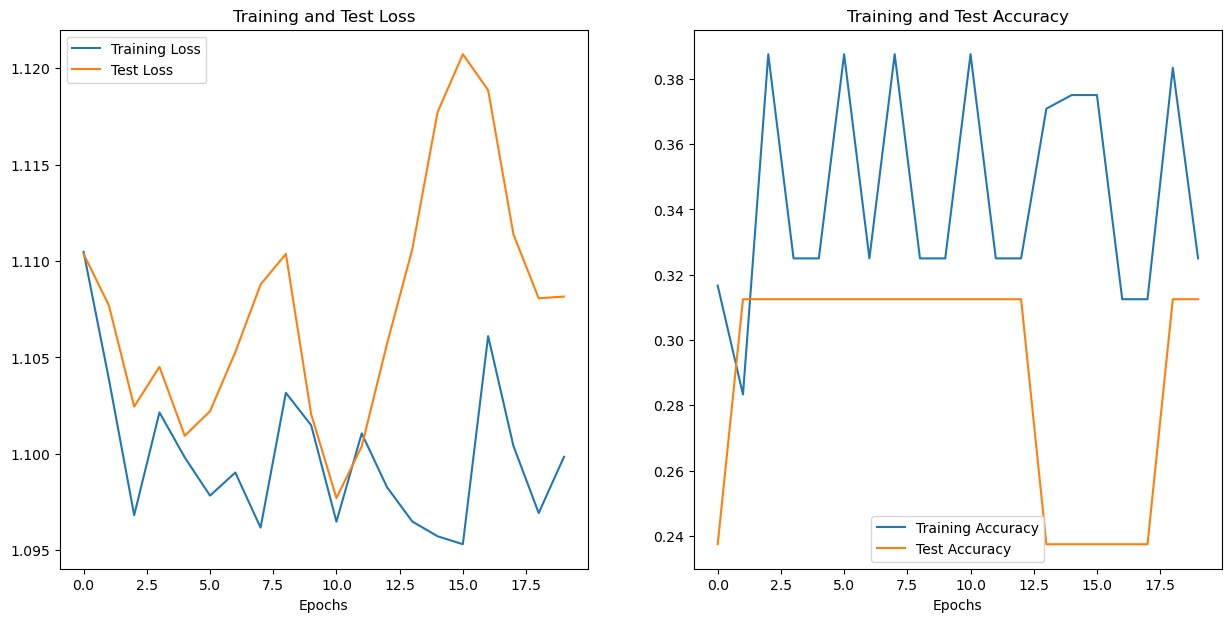

In [65]:
plot_results(model_2_results)

In [66]:
import requests

custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        f.write(requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/e9e603d84d5be22c45ee03295819d043c77f339b/images/04-pizza-dad.jpeg').content)
        
else:
    print(f'{custom_image_path} already exists, skipping download')


data\04-pizza-dad.jpeg already exists, skipping download


### Loading in a custom image with pytorch

We have to make sure our custom image is in the same format as our data model is trained on.

* In tenor torch.float32
* In tensor.shape (3,64,64)
* Data on correct device

In [67]:
import torch
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(custom_image_uint8)

print(f"Image shape: {custom_image_uint8.shape}")
print(f"Image datatype: {custom_image_uint8.dtype}")

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Image shape: torch.Size([3, 4032, 3024])
Image datatype: torch.uint8


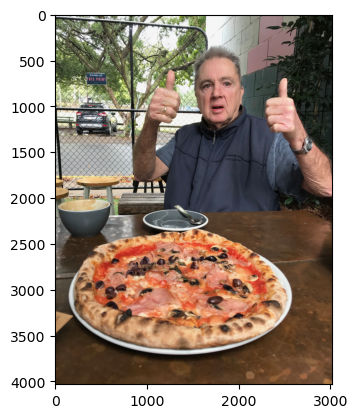

In [68]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

### Make a prediction on custom data with the trained model

In [69]:
# Convert the image to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) /255

In [70]:
# Resize the image to (64,64)
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Transformed image shape: {custom_image_transformed.shape}")
print(f"Original: {custom_image.shape}")

Transformed image shape: torch.Size([3, 64, 64])
Original: torch.Size([3, 4032, 3024])


c:\Users\jakev\anaconda3\envs\env\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


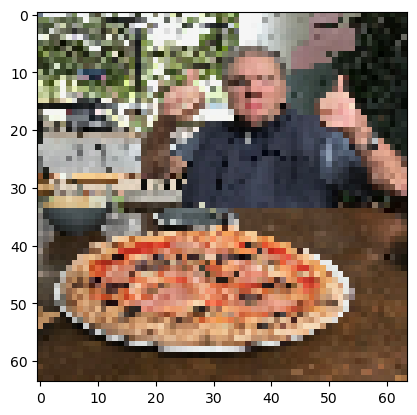

In [71]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [72]:
Model_V0.eval()
with torch.inference_mode():
    custom_image_preds = Model_V0(custom_image_transformed.unsqueeze(0).to(device))
    
custom_image_preds

tensor([[-0.0621, -0.2142,  0.1155]], device='cuda:0')

In [73]:
class_names

['pizza', 'steak', 'sushi']

### To make predictions on a single image, you must

1. Load the image and transform it into a tensor
2. Make sure the image was the same datatype as the model
3. Make sure ht image was the same shape (1,3,64,64)
4. And put the image on the same device

In [74]:
# Convert logit into probabilities
custom_image_probs = torch.softmax(custom_image_preds, dim=1)
print(custom_image_probs)

# Convert probabilities to class name
class_name_label = class_names[torch.argmax(custom_image_probs)]
print(class_name_label)



tensor([[0.3275, 0.2813, 0.3912]], device='cuda:0')
sushi


### Fuctionize the custom image prediction

Ideal outcome:

A function where an imge path is passed, and the it will convert to a tensor and provide a prediction

In [92]:
from torchvision.transforms import Resize, Compose

import torchvision
import torch.nn.functional as F
def predict_and_plot(model: nn.Module,
                     image_path: str,
                     device: torch.device,
                     class_names: List[str] = None,
                     transform: Compose = None,
                     target_size: Tuple[int, int] = (64, 64)):
    
    # Read in the image
    image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255
    image = Compose([Resize(target_size)])(image)
    
    # Transform the image if necessary
    if transform:
        image = transform(image)
        
    # Put model on the target device
    model.to(device)
    
    # Make a prediction
    model.eval()
    with torch.inference_mode():
        preds = model(image.unsqueeze(0).to(device))

    
        # Convert the logits to probabilities
        probs = F.softmax(preds, dim=1)
        
        # Get the predicted class label
        pred_label = torch.argmax(probs, dim=1).item()
        
        # Get the class probability
        pred_prob = probs[0, pred_label].item()
        
        # Plot the image
        plt.imshow(image.permute(1, 2, 0))
        if class_names:
            plt.title(f"Pred: {class_names[pred_label]}\nProb: {pred_prob*100:.2f}%")
        plt.axis(False)
        

c:\Users\jakev\anaconda3\envs\env\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


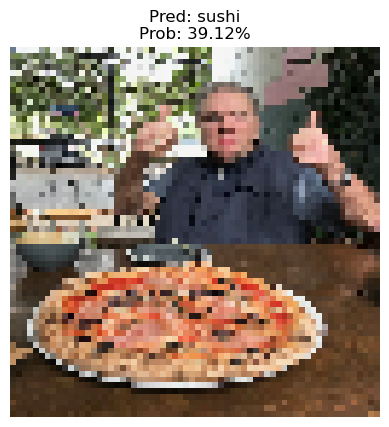

In [93]:
predict_and_plot(model=Model_V0,
                 image_path=custom_image_path,
                 target_size=(64,64),
                 class_names=class_names,
                 transform=None,
                 device=device)

In [91]:
device

'cuda'